
DATASET                                                                TP      FP      TN      FN     sum
HardwareClassifier fullscale_downsampled                               937952  532     13019249 289095416848687 -> Acc = 82.84%, TPR = 99.9433%


/cr/users/filip/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/cr/users/filip/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/cr/users/filip/Binaries/__config__.py:19: RuntimeWarning: overflow encountered in exp
  return efficiency * (1 - 1 / (1 + np.exp(-scale * (x - p50))))
/cr/users/filip/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/cr/users/filip/Binaries/__config__.py:19: RuntimeWarning: overflow encountered in exp
  return efficiency * (1 - 1 / (1 + np.exp(-scale * (x - p50))))
/cr/users/filip/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/cr/users/filip/Bina

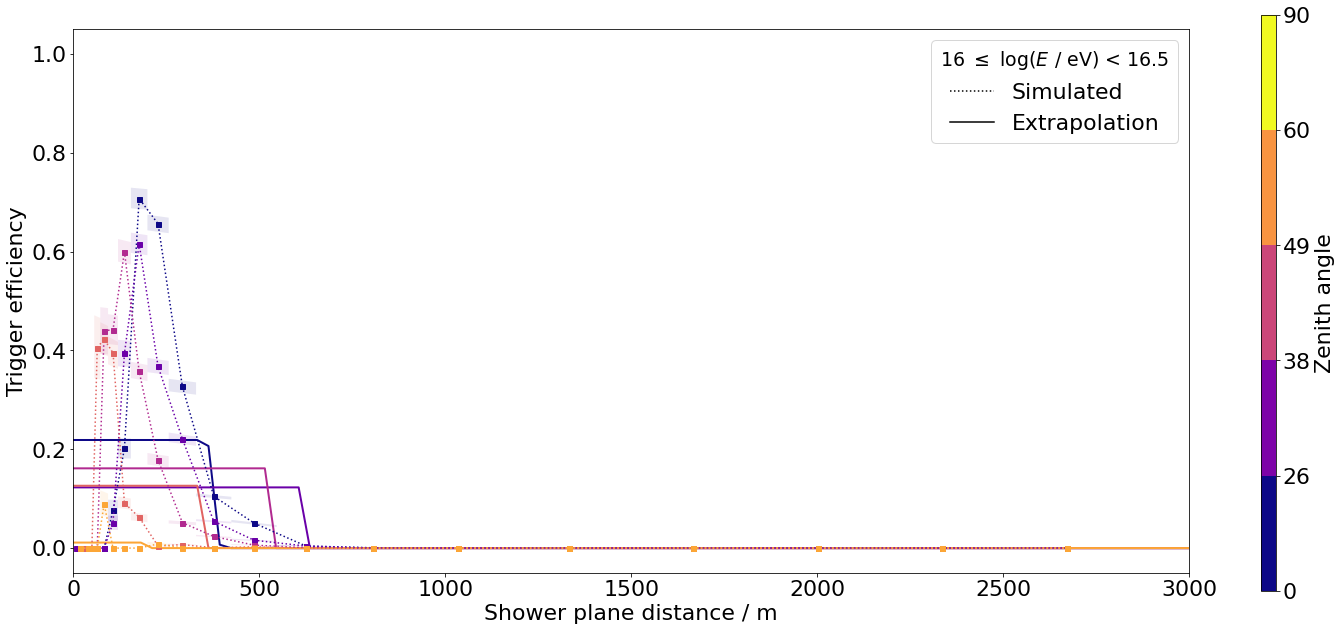

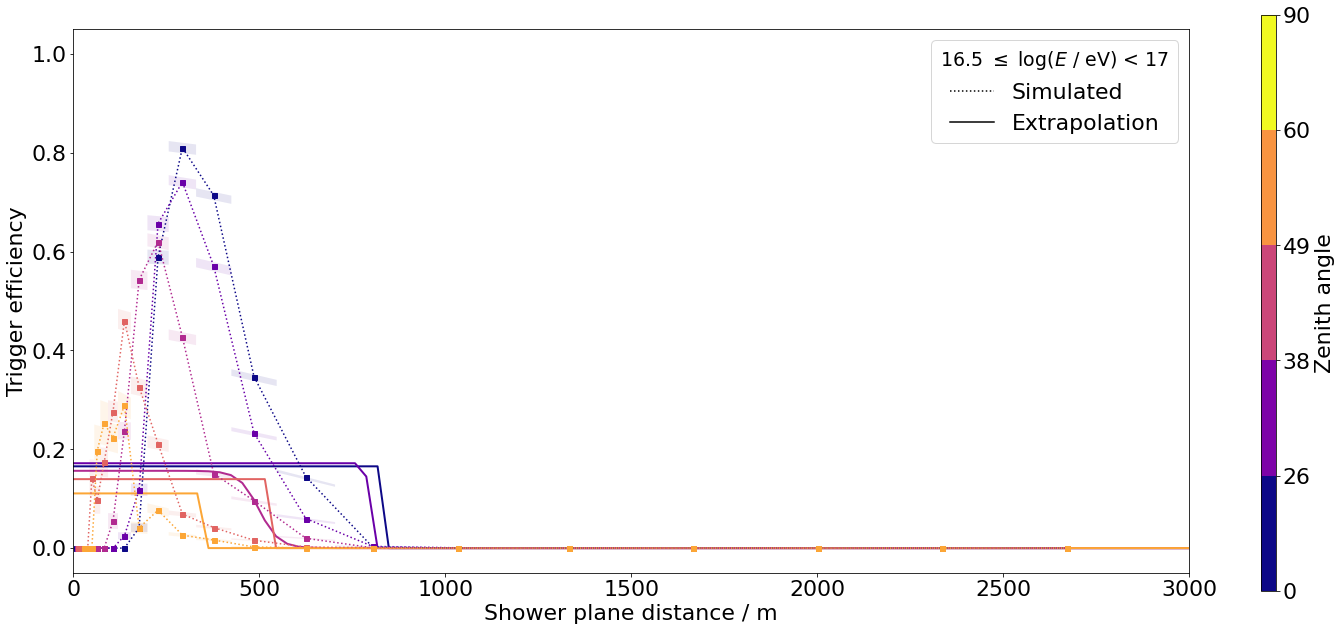

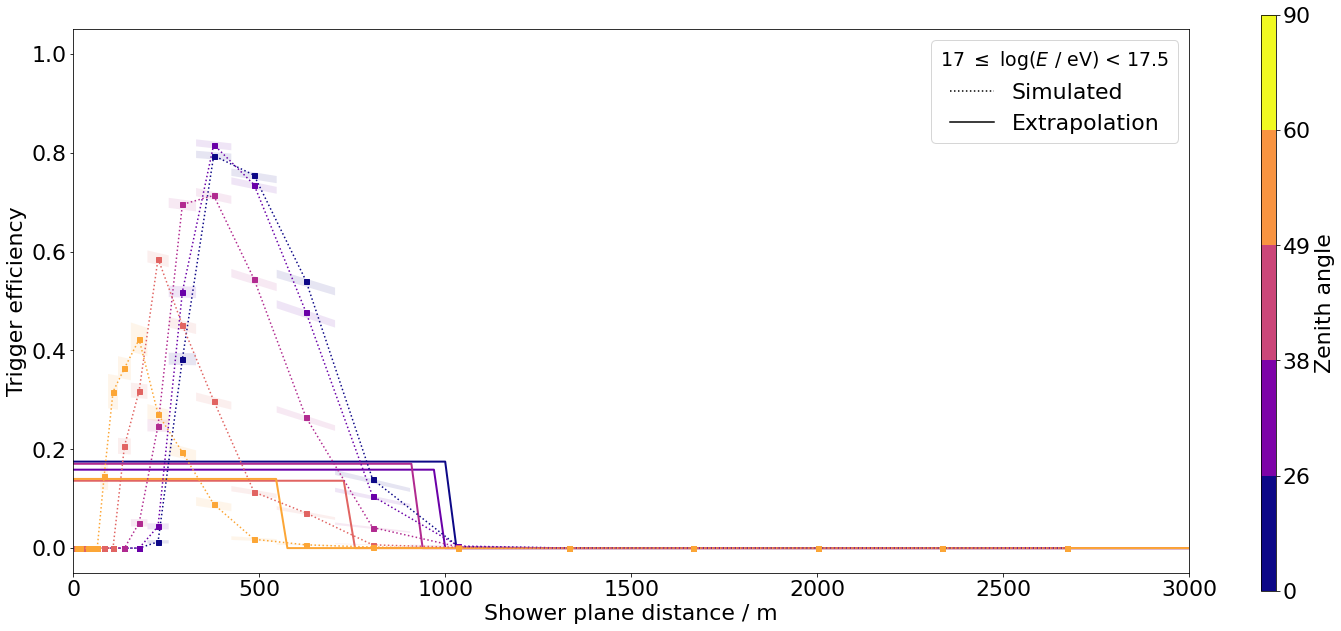

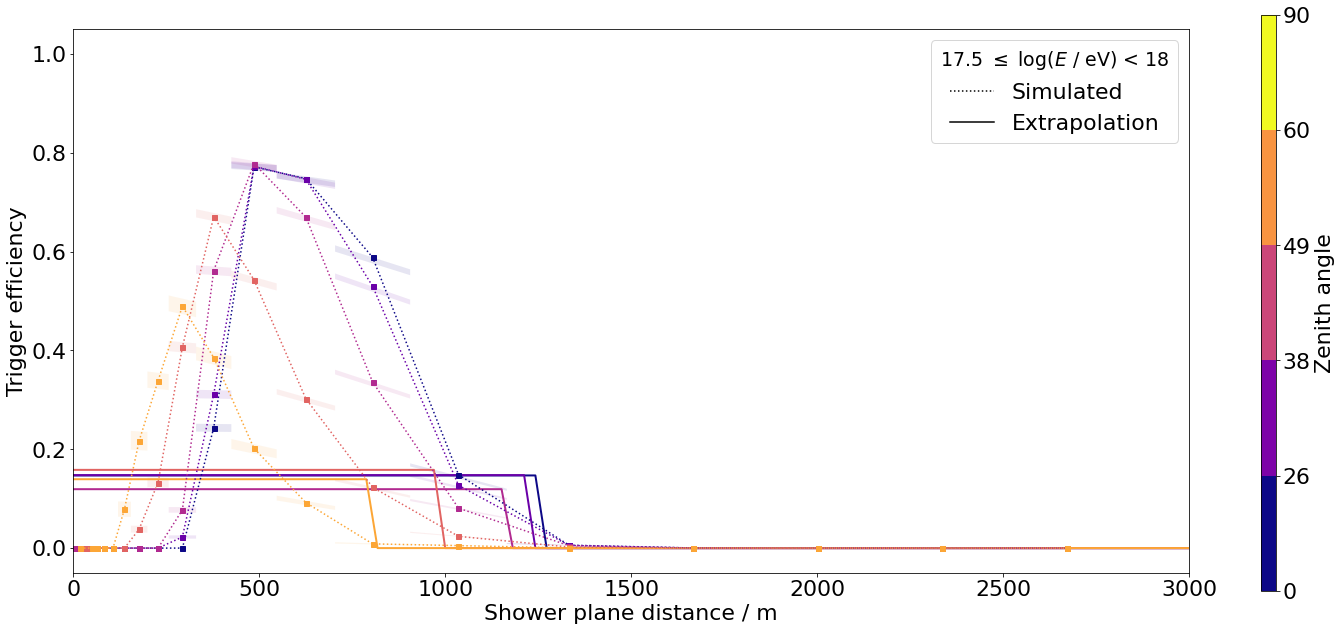

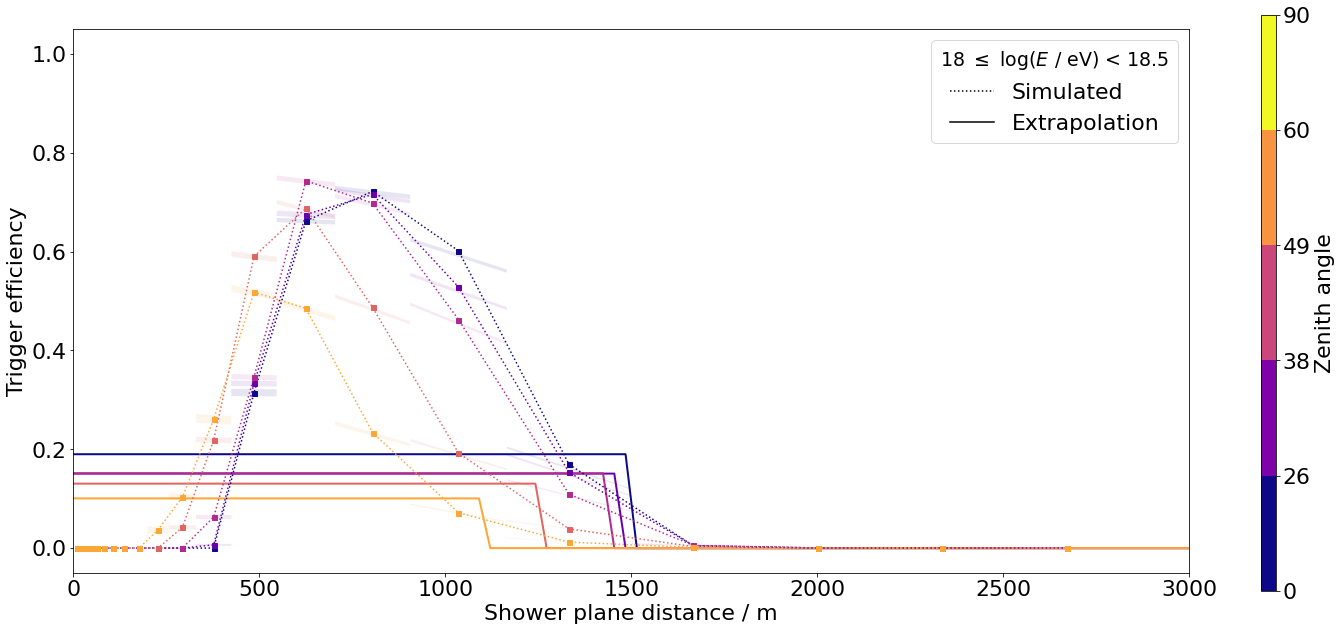

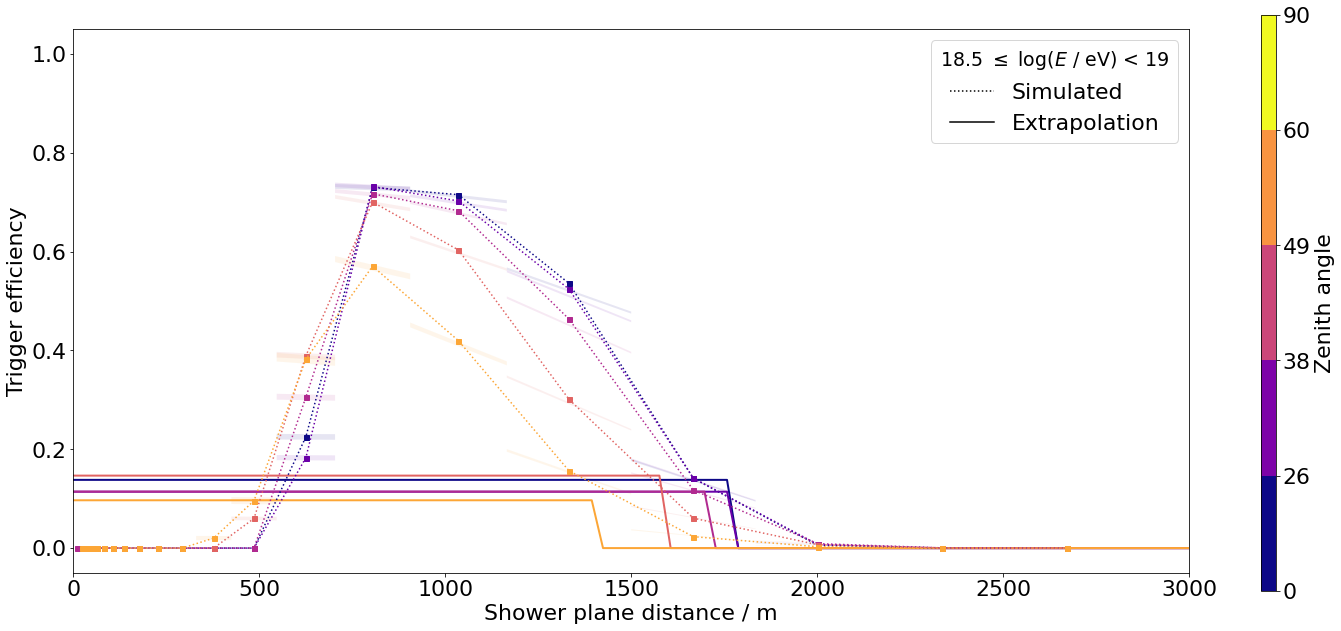

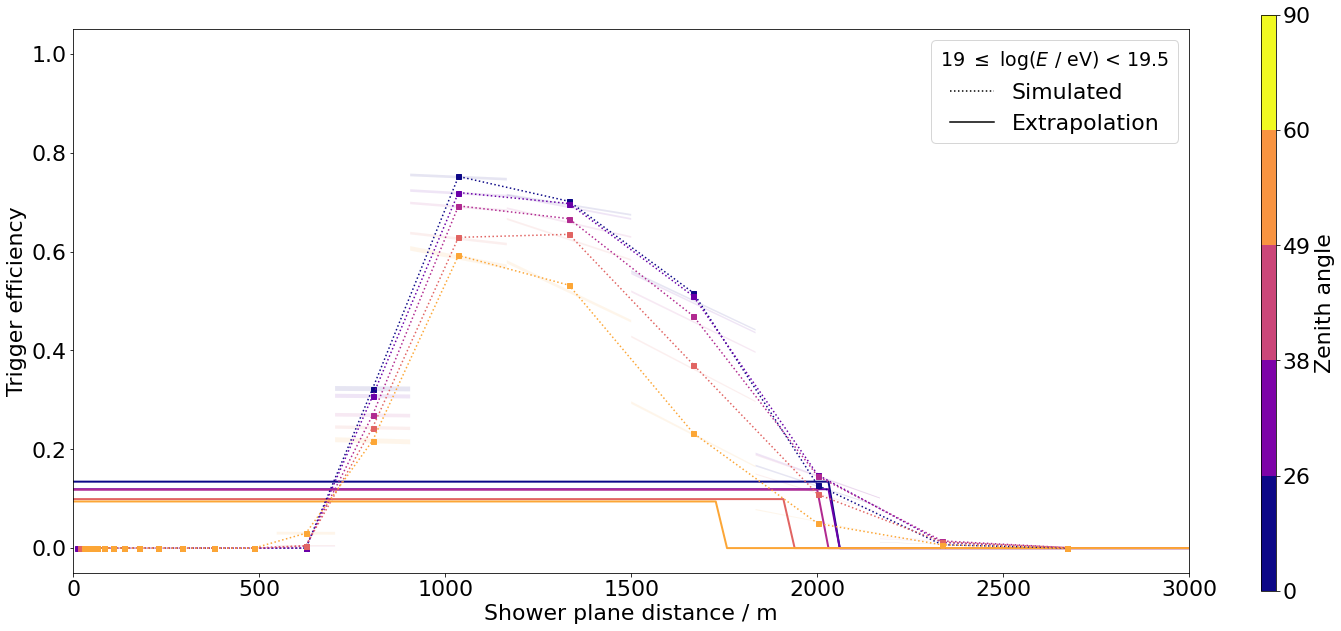

In [1]:
from Binaries import *
plt.rcParams["figure.figsize"] = [20, 10]

Hardware = HardwareClassifier()
fit_info = Hardware.spd_energy_efficiency("fullscale_downsampled", quiet = False)

In [ ]:
# accuracies, p50s, scales
import seaborn as sns
plt.rcParams["figure.figsize"] = [20, 15]

e_labels = EventGenerator.libraries.keys()
t_labels = ["0_26", "26_38", "38_49", "49_60", "60_90"]

fit_params = fit_info[0]

accuracy = fit_params[:,:,0]
p50 = fit_params[:,:,1]
scale = fit_params[:,:,2]

sns.heatmap(accuracy * 1e2, annot = True, fmt = ".1f", cbar_kws = {"label" : "Fitted accuracy / %"})
plt.xticks(ticks = 0.5 + np.arange(0, 5, 1), labels = t_labels)
plt.yticks(ticks = 0.5 + np.arange(0, 7, 1), labels = e_labels)
plt.xlabel("Zenith range")
plt.ylabel("Energy range")

plt.figure()
sns.heatmap(p50, annot = True, fmt = ".0f", cbar_kws = {"label" : "Fitted p50 / m"})
plt.xticks(ticks = 0.5 + np.arange(0, 5, 1), labels = t_labels)
plt.yticks(ticks = 0.5 + np.arange(0, 7, 1), labels = e_labels)
plt.xlabel("Zenith range")
plt.ylabel("Energy range")

plt.figure()
sns.heatmap(scale, annot = True, fmt = ".2e", cbar_kws = {"label" : r"Fitted scale / m$^{-1}$"})
plt.xticks(ticks = 0.5 + np.arange(0, 5, 1), labels = t_labels)
plt.yticks(ticks = 0.5 + np.arange(0, 7, 1), labels = e_labels)
plt.xlabel("Zenith range")
plt.ylabel("Energy range")

In [ ]:
def confidence_comparison(confidence_level, *args, **kwargs):

    labels = kwargs.get("labels", None)
    energy_labels = ["16_16.5", "16.5_17", "17_17.5", "17.5_18", "18_18.5", "18.5_19", "19_19.5"]
    theta_labels = [r"$0^\circ$", r"$26^\circ$", r"$38^\circ$", r"$49^\circ$", r"$60^\circ$", r"$90^\circ$"]
    colors = ["steelblue", "orange", "green"]

    try:
        if labels and len(labels) != len(args): raise ValueError
    except:
        sys.exit("Provided labels doesn't match the provided fit parameters")

    fig, axes = plt.subplots(nrows = len(theta_labels) - 1, sharex = True, sharey = True)
    axes[0].set_title(f"Trigger characteristics for r$_{{{confidence_level * 1e2:.0f}}}$")

    for i, fit_info in enumerate(args):
        fit_params, fit_uncertainties = fit_info
        
        for e, energy in enumerate(fit_params):
            for t, theta in enumerate(energy):
                acc, p50, scale = theta
                pcov = fit_uncertainties[e,t]

                station_trigger_probability = lambda x : station_hit_probability(x, acc, p50, scale)
                inverse_trigger_probability = lambda y : p50 - np.log(acc/(1-y) - 1) / scale

                # calculate gradient
                exp = lambda x, k, b : np.exp(-k * (x - b))
                d_accuracy = station_trigger_probability(confidence_level) / acc
                d_p50 = acc * scale * exp(confidence_level, scale, p50) / (1 + exp(confidence_level, scale, p50))**2
                d_scale = acc * (p50 - confidence_level) * exp(confidence_level, scale, p50) / (1 + exp(confidence_level, scale, p50))**2
                grad = np.array([d_accuracy, d_p50, d_scale])
                y_err = np.sqrt( grad.T @ pcov @ grad.T )

                axes[t].errorbar(e, inverse_trigger_probability(confidence_level), xerr = 0.5, yerr = y_err, capsize = 3, c = colors[i], elinewidth = 1, fmt = "s")

    axes[0].set_xticks(range(7), energy_labels)

    fig.text(0.5, 0.04, 'Energy range', ha='center', fontsize = 27)
    fig.text(0.04, 0.5, 'Detection radius / m', va='center', rotation='vertical', fontsize = 27)
    
    for i, ax in enumerate(axes):
        if labels: 
            for ii, label in enumerate(labels):
                ax.scatter([], [], marker = "s", c = colors[ii], label = labels[ii])

        ax.legend(title = theta_labels[i] + r"$\leq$ $\theta$ < " + theta_labels[i + 1])
        ax.axhline(0, c = "gray", ls = ":", lw = 2)

In [ ]:
confidence_comparison(0.95, fit_info, labels = ["Hardware"])

In [ ]:
with open("/cr/users/filip/Trigger/ImplementationTest/fit_param_example.csv", "w") as file:
    for energy in fit_params:
        np.savetxt(file, energy)